In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve,precision_recall_curve
from sklearn.base import clone
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.base import BaseEstimator
import catboost as cat
from tqdm import tqdm
from sklearn import model_selection
import itertools

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_hue_oof(params, X, y, X_test,
                cv_scheme='kf', n_splits=5, shuffle=False, seed=42,
                metrics=None,n_estimators=5000,
                verbose=500,early_stopping_rounds=100):
    if metrics is None:
        metrics = [('f1', f1_score)]
    if cv_scheme is 'kf':
        cv_split = model_selection.KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    elif cv_scheme is 'skf':
        cv_split = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    else:
        cv_split = model_selection.TimeSeriesSplit(n_splits=n_splits)

    S_train = np.zeros((X.shape[0],))
    S_test = np.zeros((X_test.shape[0],))
    
    cms=[]
    scores = pd.DataFrame()
    feature_importance = pd.DataFrame()
    for metric_name, metric in metrics:
        scores[metric_name] = np.ndarray((n_splits,))
    columns = X.columns
    for fold_n, (tr_idx, val_idx) in enumerate(cv_split.split(X,y)):
        if type(X) is np.ndarray:
            X_tr, X_val = X[columns][tr_idx], X[columns][val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
        else:
            X_tr, X_val = X[columns].iloc[tr_idx], X[columns].iloc[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
            
            model = lgb.LGBMClassifier(**params, 
                                       n_estimators=n_estimators, 
                                       n_jobs = -1)
            model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], 
                    eval_metric=eval_auc,
                    verbose=verbose, 
                    early_stopping_rounds=early_stopping_rounds)
            
            oof_pred = model.predict_proba(X_val)[:, 1]
            test_pred = model.predict_proba(X_test, 
                                         num_iteration=model.best_iteration_)[:, 1]

        for_metrics = model.predict(X_val)
        for (metric_name, metric) in metrics:
            scores.loc[fold_n, metric_name] = metric(y_val, for_metrics)

        S_train[val_idx] = oof_pred.ravel()
        S_test += test_pred
        
        cms.append(confusion_matrix(y_val, for_metrics))
        
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
    S_test /= n_splits
    
    feature_importance["importance"] /= n_splits
    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
    plt.figure(figsize=(16, 12));
    sns.barplot(x="importance", 
                y="feature", 
                data=best_features.sort_values(by="importance", ascending=False));
    plt.title('LGB Features (avg over folds)');
    
    cm = np.average(cms, axis=0)
    plt.figure()
    plot_confusion_matrix(cm, 
                      classes=[0,1], 
                      title= 'LGB Confusion matrix [averaged/folds]')
    
    print('=' * 60)
    for metric in scores.columns:
        print(f'[{metric}]\t', 'CV mean:', np.mean(scores[metric]), ', std:', np.std(scores[metric]))
    return S_train.reshape(-1, 1), S_test.reshape(-1, 1)

def reduce_memory_usage(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
            start_mem - end_mem) / start_mem))
    
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    return 'auc', fast_auc(y_true, y_pred), True

def get_df(df_path, dtypes_path):
    path = '../input/ieee-cis-data/'
    df_dtypes = pd.read_csv(path + dtypes_path)
    df_dtypes = df_dtypes.rename(columns={'TransactionID': 'col','int32': 'type'})
    df_dtypes = df_dtypes.to_dict(orient='records')
    new_dtypes = dict()
    for rec in df_dtypes:
        new_dtypes[rec['col']] = rec['type']
    new_dtypes['TransactionID'] = 'int32'

    df = pd.read_csv(path+df_path, dtype=new_dtypes)
    del df_dtypes, new_dtypes
    gc.collect()
    return df

class TargetSmoothedEncoder:
    def __init__(self, cols=None, alpha=5):
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        self.alpha = alpha

    def fit(self, X, y):
        if self.cols is None:
            self.cols = [col for col in X if str(X[col].dtype) == 'object']

        for col in self.cols:
            if col not in X:
                raise ValueError('Column', col, ' not in X')

        self.maps = dict()
        for col in self.cols:
            global_mean = y.mean()
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                nrows = y[X[col] == unique].count()
                mean = y[X[col] == unique].mean()
                tmap[unique] = (mean * nrows + global_mean * self.alpha) / (nrows + self.alpha)
            self.maps[col] = tmap

        return self

    def transform(self, X):
        res = X[self.cols].copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col] == val] = mean_target
            res[col] = vals
        return res

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


class TargetEncoderCV:
    def __init__(self, cols=None, n_splits=3, shuffle=True, seed=0):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.seed = seed
        self.cols = cols

    def fit(self, X, y):
        self.target_encoder = TargetSmoothedEncoder(cols=self.cols).fit(X, y)
        return self

    def transform(self, X, y=None):
        # Use target encoding from fit() if this is test data
        if y is None:
            return self.target_encoder.transform(X)

        kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.seed)
        res = X[self.cols].copy()
        for tr_idx, val_idx in kf.split(X):
            te = TargetSmoothedEncoder(cols=self.cols).fit(X.iloc[tr_idx, :], y.iloc[tr_idx])
            res.iloc[val_idx, :] = te.transform(X.iloc[val_idx, :])
        return res

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
def do_groupby(feat, by,trans=['mean','std']):
    for trans_ in trans:
        train[feat+'_to_'+trans_+'_'+by] = train[feat] / train.groupby([by])[feat].transform(trans_)
        test[feat+'_to_'+trans_+'_'+by] = test[feat] / test.groupby([by])[feat].transform(trans_)

In [3]:
train = get_df('train.csv', 'train_dtypes.csv')
test = get_df('test.csv', 'test_dtypes.csv')
sub = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [4]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
skewed_cols = [col for col in train.columns if train[col].value_counts(normalize=True).values[0] > 0.95]
skewed_cols_test = [col for col in test.columns if test[col].value_counts(normalize=True).values[0] > 0.95]
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + skewed_cols + skewed_cols_test+
                        big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [5]:
gc.collect()

27

In [7]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)

test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

In [8]:
gc.collect()

40

In [9]:
train.loc[
    train.DeviceInfo.isin(
        train.DeviceInfo.value_counts()[train.DeviceInfo.value_counts() < 50].index), 
    'DeviceInfo'] = "Others"

In [11]:
train = train.drop(['P_emaildomain_3', 'R_emaildomain_3','P_emaildomain','R_emaildomain'], axis=1)
test = test.drop(['P_emaildomain_3', 'R_emaildomain_3','P_emaildomain','R_emaildomain'], axis=1)

In [12]:
gc.collect()

28

In [14]:
do_groupby('TransactionAmt','card1',['mean'])
do_groupby('TransactionAmt','card3',['mean'])
do_groupby('TransactionAmt','card5',['mean'])
do_groupby('TransactionAmt','card2',['mean','std'])
do_groupby('TransactionAmt','card4',['mean','std'])
# do_groupby('TransactionAmt','dist1',['mean'])
do_groupby('TransactionAmt','ProductCD',['mean','std'])
do_groupby('TransactionAmt','addr1',['mean'])
# do_groupby('TransactionAmt','DeviceInfo',['mean','std'])
do_groupby('TransactionAmt','P_emaildomain_1',['mean','std'])
do_groupby('TransactionAmt','R_emaildomain_1',['mean','std'])

do_groupby('D15','card1',['mean'])
do_groupby('D15','card3',['mean'])
do_groupby('D15','card5',['mean'])
do_groupby('D15','card2',['mean','std'])
do_groupby('D15','card4',['mean','std'])
# do_groupby('D15','dist1',['mean'])
# do_groupby('D15','ProductCD',['mean','std'])
# do_groupby('D15','addr1',['mean'])

# do_groupby('Weekday','TransactionAmt',['mean','std'])
# do_groupby('Hour','TransactionAmt',['mean','std'])
# do_groupby('Day','TransactionAmt',['mean','std'])

In [15]:
# train = train[chosen_cols]
# chosen_cols.remove('isFraud')
# test = test[chosen_cols]

In [16]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]
gc.collect()

78

In [17]:
obj_cols_X = list(X.select_dtypes(include=['object']).columns)
obj_cols_X_test = list(X_test.select_dtypes(include=['object']).columns)
obj_cols_X == obj_cols_X_test

True

In [18]:
for col in obj_cols_X:
    le = LabelEncoder()
    le.fit(list(X[col].astype(str).values) + list(X_test[col].astype(str).values))
    X[col] = le.transform(list(X[col].astype(str).values))
    X_test[col] = le.transform(list(X_test[col].astype(str).values))  
X_test = X_test.fillna(-999)
X = X.fillna(-999)

In [19]:
lgb_params = {
    "boosting_type": "gbdt",
    'objective': 'binary',
    "metric": 'auc',
    'max_depth': 7,
    'num_leaves': 50,
    'learning_rate': 0.03,
    'min_child_samples': 70,
    
    "subsample_freq": 3,
    "subsample": 0.9,
    "bagging_seed": 24,
    "verbosity": -1,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'colsample_bytree': 0.9,
}
model = lgb.LGBMClassifier(**lgb_params, 
                                       n_estimators=1000, 
                                       n_jobs = -1)

In [20]:
from sklearn.feature_selection import SelectFromModel
embeded_lgb_selector = SelectFromModel(model, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(bagging_seed=24, boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.9,
                                         importance_type='split',
                                         learning_rate=0.03, max_depth=7,
                                         metric='auc', min_child_samples=70,
                                         min_child_weight=0.001,
                                         min_split_gain=0.0, n_estimators=1000,
                                         n_jobs=-1, num_leaves=50,
                                         objective='binary', random_state=None,
                                         reg_alpha=0.3, reg_lambda=0.3,
                                         silent=True, subsample=0.9,
                                         subsample_for_bin=200000,
                                         subsample_freq=3, verbosity=-1),
      

In [21]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

146 selected features


In [22]:
embeded_lgb_feature

['TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'dist1',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M9',
 'V12',
 'V13',
 'V19',
 'V20',
 'V29',
 'V35',
 'V36',
 'V37',
 'V38',
 'V44',
 'V45',
 'V53',
 'V54',
 'V56',
 'V61',
 'V62',
 'V75',
 'V76',
 'V78',
 'V81',
 'V82',
 'V83',
 'V87',
 'V91',
 'V96',
 'V99',
 'V126',
 'V127',
 'V130',
 'V131',
 'V139',
 'V152',
 'V160',
 'V164',
 'V165',
 'V187',
 'V207',
 'V208',
 'V210',
 'V220',
 'V258',
 'V261',
 'V264',
 'V266',
 'V267',
 'V268',
 'V271',
 'V277',
 'V278',
 'V282',
 'V283',
 'V285',
 'V288',
 'V291',
 'V294',
 'V306',
 'V307',
 'V308',
 'V310',
 'V312',
 'V313',
 'V314',
 'V315',
 'V317',
 'id_01',
 'id_02',
 'id_05',
 'id_06',
 'id_09',
 'id_13',
 'id_14',
 'id_17',
 'id_19',
 'id_20',
 '

In [23]:
X = X[embeded_lgb_feature]
X_test = X_test[embeded_lgb_feature]

In [24]:
from imblearn.over_sampling import SMOTE
X.shape, y.shape

Using TensorFlow backend.


((590540, 146), (590540,))

In [25]:
gc.collect()

22

In [26]:
lgb_params = {
    "boosting_type": "gbdt",
    'objective': 'binary',
    "metric": 'auc',
    'max_depth': 7,
    'num_leaves': 50,
    'learning_rate': 0.03,
    'min_child_samples': 70,
    
    "subsample_freq": 3,
    "subsample": 0.9,
    "bagging_seed": 24,
    "verbosity": -1,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'colsample_bytree': 0.9,
}
metrics =[
    ('f1', f1_score),
    ('prec', precision_score),
    ('rec', recall_score),
    ('roc_auc',roc_auc_score)
]

sm = SMOTE(random_state=42, sampling_strategy=0.2)
X_sm,y_sm = sm.fit_sample(X, y)
X_sm = pd.DataFrame(X_sm, columns=X.columns)
y_sm = pd.DataFrame(y_sm)

del X,y
gc.collect()

6

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.971445	training's auc: 0.971445	valid_1's auc: 0.970512	valid_1's auc: 0.970512
[200]	training's auc: 0.981665	training's auc: 0.981665	valid_1's auc: 0.980445	valid_1's auc: 0.980445
[300]	training's auc: 0.985315	training's auc: 0.985315	valid_1's auc: 0.983737	valid_1's auc: 0.983737
[400]	training's auc: 0.987358	training's auc: 0.987358	valid_1's auc: 0.985407	valid_1's auc: 0.985407
[500]	training's auc: 0.988826	training's auc: 0.988826	valid_1's auc: 0.986556	valid_1's auc: 0.986556
[600]	training's auc: 0.990033	training's auc: 0.990033	valid_1's auc: 0.987495	valid_1's auc: 0.987495
[700]	training's auc: 0.991139	training's auc: 0.991139	valid_1's auc: 0.988368	valid_1's auc: 0.988368
[800]	training's auc: 0.991974	training's auc: 0.991974	valid_1's auc: 0.988945	valid_1's auc: 0.988945
[900]	training's auc: 0.992783	training's auc: 0.992783	valid_1's auc: 0.98953	valid_1's auc: 0.98953
[10

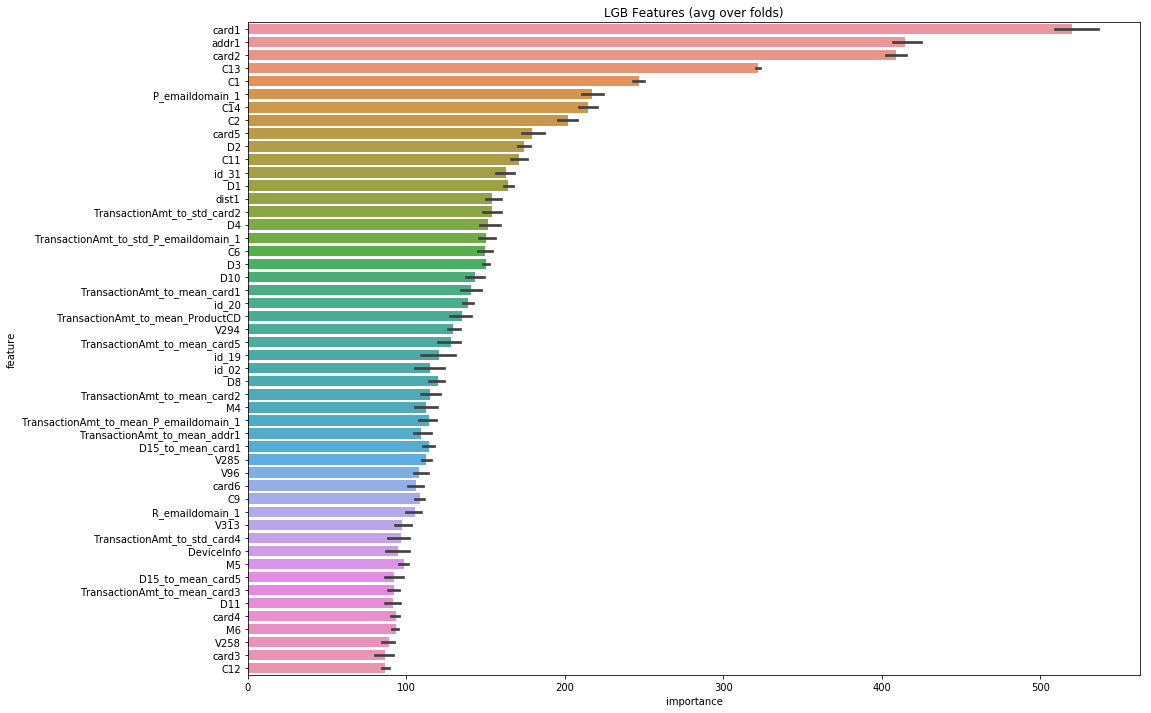

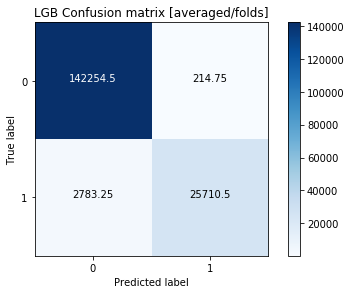

In [27]:
oof_lgb, pred_lgb = get_hue_oof(lgb_params, X=X_sm, y=y_sm[0], X_test=X_test,
                    cv_scheme='skf', n_splits=4, shuffle=True, seed=42,
                    metrics=metrics,n_estimators=1000,verbose=100)

In [29]:
test = test.sort_values('TransactionDT')
test['prediction'] = pred_lgb
sub['isFraud'] = pd.merge(sub, test, on='TransactionID')['prediction']
sub.to_csv('smote.csv', index=False)

In [30]:
sub.tail()

,TransactionID,isFraud
506686,4170235,0.037612864149001
506687,4170236,0.012299067415617
506688,4170237,0.010248888725384
506689,4170238,0.016705985736948
506690,4170239,0.007576465838932
